<a href="https://colab.research.google.com/github/microprediction/monteprediction_colab_examples/blob/main/monteprediction_entry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sector Monte Carlo Game

I'm looking for people to help blow away traditional index investing as the world knows it, using a marvellous monte-mutuel meritocracy. Those who choose to be part of this new venture submit one million scenarios for next week's sector returns, and do so every weekend. Each scenario comprises 11 numbers, one for each financial sector. Every week the following are updated:

*   [Weekly likelihood scores](https://www.monteprediction.com/weekly)
*   [Wealth](https://www.monteprediction.com/)

Loosely speaking you are rewarded based on how many of your samples are close to the ground truth (and in the case of wealth, how many of your competitors are also close - precise details below).

You can participate by running this notebook.

* Change the email and name below and, prefereably,
* Modify this example notebook first to *improve the algorithm* (and I mean *completely replace it* as you see fit. Chatgpt can help (see the [example](https://github.com/microprediction/monteprediction_colab_examples/blob/main/monteprediction_predict_o1_matrix_using_copulas.ipynb) created by Open AI's o1-preview.).  

Once you get the joke, you'll need to script this up to run it every week - I would suggest on a Saturday. The ground truth is calculated Monday close to Monday close, but to allow for various uses of the data, the cutoff for submissions is Sunday mightnight UTC.



In [ ]:
!pip install scikit-learn
!pip install scipy
!pip install --upgrade monteprediction

import yfinance as yf
import pandas as pd
import seaborn as sns

import numpy as np
from datetime import datetime, timedelta
import time
from monteprediction import SPDR_ETFS
from monteprediction.calendarutil import get_last_wednesday
from monteprediction.submission import send_in_chunks

# Tournament settings, don't change these.
num_samples_per_chunk = int(1048576/8)
num_chunks = 8
num_samples = num_chunks*num_samples_per_chunk

## Step 1. Create a dataframe with just over one million hypothetical weekly returns for each sector.   

Do this however you like this is just an example. One column per sector.

In [ ]:
# This example uses Quasi-Monte Carlo on the empirical covariance
# There is absolutely no requirement you follow this pattern

from scipy.stats.qmc import MultivariateNormalQMC
from sklearn.covariance import EmpiricalCovariance

# Get historical weekly returns
last_wednesday = get_last_wednesday()
num_weeks = int(52+4*52*np.random.rand())
start_date = last_wednesday - timedelta(weeks=num_weeks)
data = yf.download(SPDR_ETFS, start=start_date, end=last_wednesday, interval="1wk")
weekly_prices = data['Adj Close']
weekly_returns = weekly_prices.pct_change().dropna()

# Use cov estimation to generate samples
cov_matrix = EmpiricalCovariance().fit(weekly_returns).covariance_
qmc_engine = MultivariateNormalQMC(mean=np.zeros(len(SPDR_ETFS)), cov=cov_matrix)
samples = qmc_engine.random(num_samples)
df = pd.DataFrame(columns=SPDR_ETFS, data = samples)
print(df[:3])

# Verify submission
assert len(df.index)==num_samples,f'Expecting exactly {num_samples} samples'
assert list(df.columns)==SPDR_ETFS,'Columns should match SPDR_ETFS in order'


[*********************100%%**********************]  11 of 11 completed


        XLB       XLC       XLE       XLF       XLI       XLK       XLP  \
0 -0.005739 -0.027379  0.055381 -0.005150 -0.007348 -0.037388  0.036084   
1  0.017681  0.012907 -0.007036  0.046401  0.040037  0.062786  0.021175   
2  0.051049  0.020684  0.054569  0.026398  0.034945  0.029755  0.021246   

       XLRE       XLU       XLV       XLY  
0  0.005877  0.045887  0.014344 -0.043577  
1  0.032060  0.006658 -0.002639  0.068654  
2  0.022588  0.006153  0.004474  0.042195  


## Step 2. Submit the dataframe

In [ ]:
YOUR_EMAIL = 'monteprediction_entry@monteprediction.com'  # Be sure to change this
YOUR_NAME  = 'Original gangster'    # The handle to be used on the leaderboard
response = send_in_chunks(df, num_chunks=num_chunks, email=YOUR_EMAIL, name=YOUR_NAME)
print(response)

Chunk 0 of 8 sent successfully.
Chunk 1 of 8 sent successfully.
Chunk 2 of 8 sent successfully.
Chunk 3 of 8 sent successfully.
Chunk 4 of 8 sent successfully.
Chunk 5 of 8 sent successfully.
Chunk 6 of 8 sent successfully.
Chunk 7 of 8 sent successfully.
{'expiry': '2024_05_20', 'message': 'Submission from monteprediction_entry@monteprediction.com received for week concluding 2024_05_20', 'name': 'Original gangster'}


## Step 3. (Later, optional) verify the submission
A more detailed check of your submission will be performed within 10-20 minutes of your submitting.

In [ ]:
from monteprediction.verification import get_verification_status
import time
time.sleep(15*60)
print(get_verification_status(email=YOUR_EMAIL))

verified


# Explaining the game ...
Here's how the reward system works.

### Weekly likelihood scores

We will assume you are participant $i$. Let's write your samples as $\{x_{ik}\}_{k=0}^{n-1}$, where each $x_{ik}$ for $k=0,\dots,2^{20}-1$ is an 11-vector. This will be used to imply an unnormalized prediction density for $z \in \mathbf{R}^{11}$ as:

$$\rho_i(z) = \frac{1}{n} \sum_{k=0}^{n-1} \exp(-a \|x_{ik}-z \|_2) $$

where $a$ is a system parameter set at approximately $a=300$. This is almost your score and approximately one week from now it will appear in the [weekly scoring](https://www.monteprediction.com/weekly). There is also an overall likelihood score although only available through the [api](https://www.monteprediction.com/api/scores) at time of writing.

### Accumulated wealth

There is also an [overall wealth](https://www.monteprediction.com/) computed for each player based on their longitudinal performance. To see how your wealth is updated each week, let us suppose you have an initial wealth $W_i$.

A system parameter $b_i=0.1$ determines the fraction of your total wealth you deploy that week. You are considered to invest $\Omega_i = b_i W_i$ and similarly for other participants yielding a total investment of $\Omega = \sum_i \Omega_i$. This pot will be split when the truth $z$ is revealed.

To this end your 'mass' is $Q_i(z) = \Omega_i \rho_i(z)$ represents loosely how many of your samples are close to $z$ weighted by your wealth. The total mass near $z$ supplied by all participants is $Q(z) = \sum_i Q_i(z)$. Your payout is $\Omega \frac{Q_i(z)}{Q(z)}$ which may be thought of as your share of the mass near the truth. Your net profit is $\delta_i(z) = \Omega \frac{Q_i(z)}{Q(z)} - \Omega_i$ and that is what dictates how your wealth ticks up or down from one week to the next.   

### Incentive

It should be apparent that $Q$ plays the role of an unnormalized market probability (i.e. risk-neutral density) and further, that a participant with perfect knowledge of the true density $P$ will at worst break even against any opponents' play, subject only to the ability to approximate $P$ with a collection of Monte Carlo paths in this fashion.

(Because this entry has been included in the mix, and is not particularly clever, there is a subsidy for participation for anyone taking even a moment to reflect statistically upon the problem ... for instance, by applying shrinkage to the covariance estimation or fixing the 1-margins).

### Minor change to scoring Apr '24

What's above isn't *entirely* true.

In April it was decided by the community that it would be better to compute likelihoods using not only the likelihood for the 11-dimensional outcome, but also adding in the likelihoods for each 10-dimensional subspace with a lower weighting.

It is hoped that this will reward more accurate predictions with greater statistical power (i.e. more skill versus luck). For avoidance of doubt you can always refer to the scoring code which is transparent and appears in the monteprediction package [here](https://github.com/microprediction/monteprediction/blob/main/monteprediction/scoring.py).

In [ ]:
# ... here's how you can verify your score...
from monteprediction.truth import get_most_recent_truth
from monteprediction.scoring import compute_score
z = get_most_recent_truth()
print({'z':z})
score = compute_score(samples=df.values,z=z)
print(f"Score using your samples above last week: {score}")


[*********************100%%**********************]  11 of 11 completed


{'z': array([-0.03072112, -0.01442068, -0.01988178, -0.03632423, -0.02204183,
       -0.0049891 , -0.0127809 , -0.02970295, -0.01473307, -0.03009355,
       -0.00967343])}
Score using your samples above last week: 1.2029812637019566


### Some suggestions

There are many critiques of this example entry, one that has been created solely to provide a template and illustrate the submission process, that might provoke you to create better entries.


1.   The distributions for each sector are assumed normal
2.   The joint distribution is assumed multivariate normal
3.   The empirical distribution is used to estimate a covariance matrix, which is typically not a brilliant idea. See instead LedoitWolf or ShrunkCovariance from [sklearn.covariance](https://scikit-learn.org/stable/modules/covariance.html), for example. You can also avail yourself of dozens of other covariance estimation methods in the [precise](https://github.com/microprediction/precise/tree/main/precise/skaters/covariance) package.

To emphasize, do not treat the above as normative in any way. If you prefer to create samples using a water computer, or copulas, or machine learning generative models (quite popular of late as per [this paper](https://cs230.stanford.edu/projects_fall_2019/reports/26259829.pdf) for example) then go for it.

You can also ask ChatGPT to improve your entry. See the [Predict-o1-Matric notebook](https://github.com/microprediction/monteprediction_colab_examples/blob/main/monteprediction_predict_o1_matrix_using_copulas.ipynb) for an example created by Open AI's o1-preview.



## Leaderboard

As noted, to go [www.monteprediction.com](www.monteprediction.com) for the weekly likelihood scores and accumulated wealth.

## Scheduling

This is a long-running tournament (perhaps forever) and the wealth will be taken rather seriously. Only those who contribute longitudinally will be rewarded (details to follow). So, it is very important to submit each and every week. I strongly suggest setting up a cron job to run on Saturdays, or otherwise ensuring that your entry is sent. There is a wealth penalty if you fail to submit.

The cutoff is Sunday mightnight UTC. If you submit after that, your scenarios will apply to the week after.

## Rules

The official rules are, or will be, at https://www.monteprediction.com/rules and superceed anything written here.

## Participant likelihood scores

The complete list of participant scores can be retrieved [directly](https://www.monteprediction.com/api/weekly) or using the helper provided:


In [ ]:
from monteprediction.api import get_weekly
import datetime
import pytz

scores_df = get_weekly()

# You may wish to convert from epoch ...

def epoch_to_new_york(epoch_time):
  tz_new_york = pytz.timezone('America/New_York')
  date_time_utc = datetime.datetime.utcfromtimestamp(epoch_time)
  date_time_new_york = date_time_utc.replace(tzinfo=datetime.timezone.utc).astimezone(tz_new_york).date()
  return date_time_new_york

scores_df['date'] = scores_df['date'].apply(epoch_to_new_york)
scores_df

,date,name,score
0,2024-05-05,Empirical benchmark,2.491296
1,2024-05-05,joakim_dot_arvidsson,2.017710
2,2024-05-05,at3325,1.608274
3,2024-05-05,thomaswcole,0.493504
4,2024-05-05,ovvo_dot_financial_dot_systems,0.252178
...,...,...,...
65,2024-02-04,langchain101,0.316611
66,2024-01-28,Original gangster,0.218671
67,2024-01-28,nobody,0.163634
68,2024-01-28,ladsf987asdf87as987afsd,0.150153


### Official ground truth

You can retrieve the official ground truth returns [directly](https://www.monteprediction.com/api/truth/2024_04_01) or using the helpers as shown below.

In [ ]:
from monteprediction.api import get_truth
get_truth('2024-04-01')

,ticker,return
0,XLB,0.020288
1,XLC,0.000745
2,XLE,0.030010
3,XLF,0.020729
4,XLI,0.009099
5,XLK,-0.006174
6,XLP,0.016951
7,XLRE,0.030532
8,XLU,0.036523
9,XLV,0.019413


## Community moments

A side benefit of being part of this obscure prediction club is access to the community covariance matrix. There is a [list of dates](https://www.monteprediction.com/api/moments) for which these are available and you can access them at URL's such as [this](https://www.monteprediction.com/api/moments/covariance/2024_04_01). There are helpers in the [Python client](https://github.com/microprediction/monteprediction/blob/main/monteprediction/api.py) for other quantities derivable from the covariance matrix.


In [ ]:
from monteprediction.api import get_mean, get_std
get_mean('2024-04-01')

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
0,0.011614,0.01426,0.019381,0.014757,0.013132,0.017884,0.010922,0.01691,0.016301,0.013361,0.020174


<Axes: >

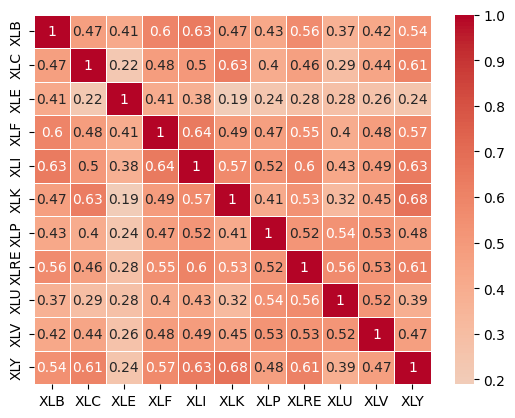

In [ ]:
from monteprediction.api import get_correlation, get_covariance
corr = get_correlation('2024-04-01')
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)